In [6]:
import scanpy as sc
import harmonypy as hm
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Load data

In [22]:
adata = sc.read_h5ad("../data/adata_merged.h5ad")
adata

AnnData object with n_obs × n_vars = 3261 × 22425
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    layers: 'counts'

# Preprocessing & batch correction

In [23]:
# 데이터 전처리 (필요시 실행)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, batch_key='sample')
# adata = adata[:, adata.var['highly_variable']]

In [24]:
# PCA 수행
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='full')

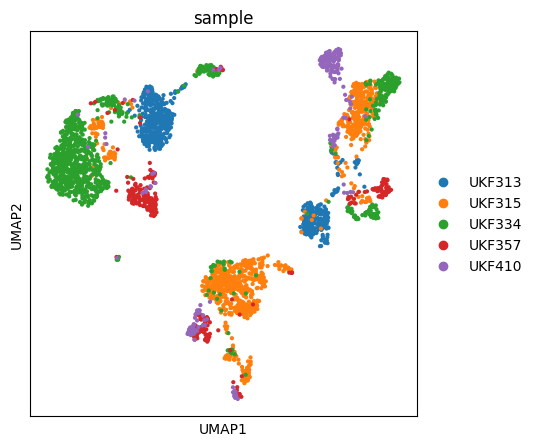

In [25]:
# UMAP 시각화
sc.pp.neighbors(adata)
sc.tl.umap(adata)
fig = sc.pl.umap(adata, color='sample', return_fig=True)
fig.set_size_inches(5, 5)
plt.show()

2024-11-08 16:18:23,964 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-08 16:18:25,472 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-08 16:18:25,484 - harmonypy - INFO - Iteration 1 of 30
2024-11-08 16:18:25,876 - harmonypy - INFO - Iteration 2 of 30
2024-11-08 16:18:26,266 - harmonypy - INFO - Iteration 3 of 30
2024-11-08 16:18:26,648 - harmonypy - INFO - Iteration 4 of 30
2024-11-08 16:18:27,044 - harmonypy - INFO - Iteration 5 of 30
2024-11-08 16:18:27,431 - harmonypy - INFO - Iteration 6 of 30
2024-11-08 16:18:27,715 - harmonypy - INFO - Iteration 7 of 30
2024-11-08 16:18:27,948 - harmonypy - INFO - Iteration 8 of 30
2024-11-08 16:18:28,116 - harmonypy - INFO - Iteration 9 of 30
2024-11-08 16:18:28,318 - harmonypy - INFO - Iteration 10 of 30
2024-11-08 16:18:28,470 - harmonypy - INFO - Iteration 11 of 30
2024-11-08 16:18:28,604 - harmonypy - INFO - Iteration 12 of 30
2024-11-08 16:18:28,758 - harmonypy - INFO - Iteration 13 of

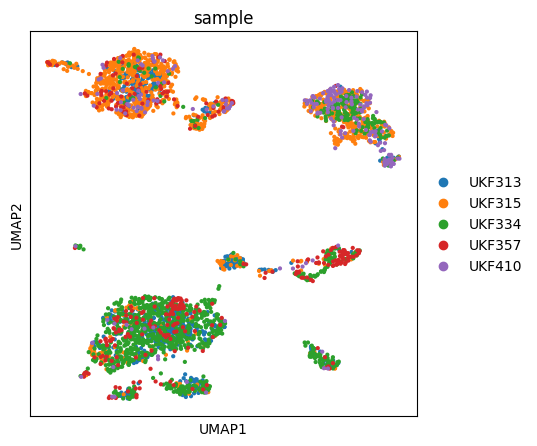

In [26]:
# Harmony로 배치 보정
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'sample', max_iter_harmony = 30)
adata.obsm['X_pca_harmony'] = ho.Z_corr.T  # Harmony 보정된 PCA 결과를 저장

# UMAP 시각화
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)
fig = sc.pl.umap(adata, color='sample', return_fig=True)
fig.set_size_inches(5, 5)
plt.show()

# Clustering

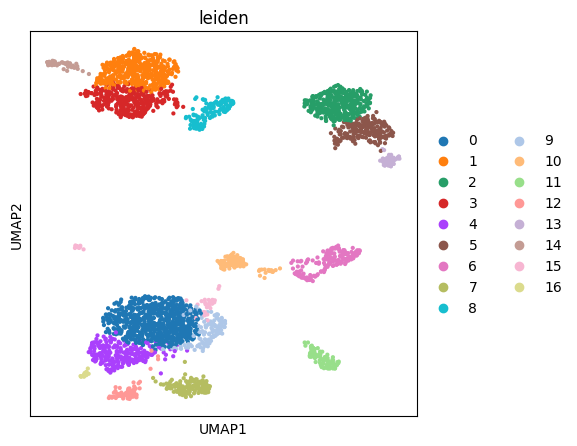

In [27]:
# leiden clustering
sc.tl.leiden(adata, resolution=1)
fig = sc.pl.umap(adata, color='leiden', return_fig=True)
fig.set_size_inches(5, 5)
plt.show()

# InferCNVpy

In [28]:
adata

AnnData object with n_obs × n_vars = 3261 × 22425
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

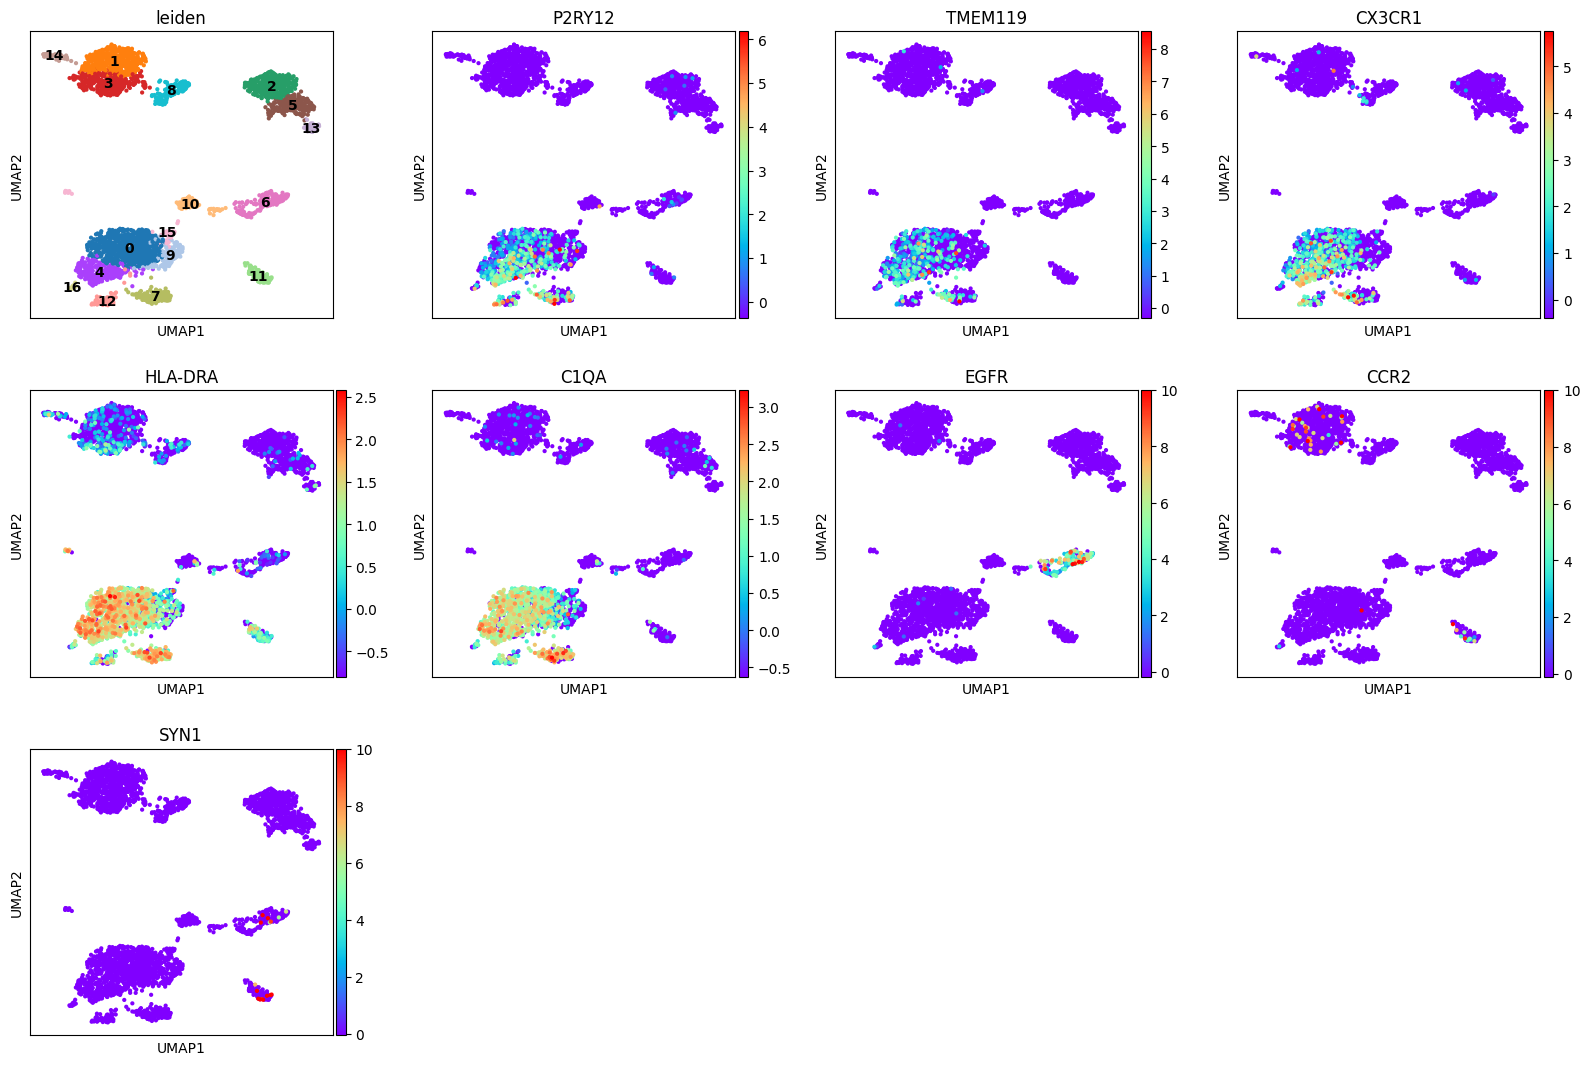

In [32]:
rcParams['figure.figsize'] = 4, 4
sc.pl.umap(
    adata,
    # color = ['leiden', 'OLIG2', 'PDGFRA', 'SOX10', 'MBP', 'MOG', 'PLP1', 'CNP', 'MAP2', 'TUBB3', 'RBFOX3', 'FN1', 'S100A4'],
    color = ['leiden', 'P2RY12', 'TMEM119', 'CX3CR1', 'HLA-DRA', 'C1QA', 'EGFR', 'CCR2', 'SYN1'],
    # color = ['leiden', 'GFAP', 'MAP2', 'SYN1', 'PTPRC', 'ITGAX', 'CCR7', 'HLA-DRA'],
    # color = ['leiden', 'CD3E', 'CD4', 'CD8A', 'FOXP3', 'NCR1', 'TRDC', 'CD19', 'PTPRC'],
    # color = ['leiden', 'SNAP25', 'SYP'],
    # frameon = False,
    legend_loc = 'on data',
    color_map = 'rainbow',
)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes = 20, sharey = False, fontsize = 10)


In [ ]:
adata.obs['tumor_cell'] = 'tumor'
adata.obs.loc[adata.obs['leiden'] == '1', 'tumor_cell'] = 'normal'
adata.obs.loc[adata.obs['leiden'] == '3', 'tumor_cell'] = 'normal'
sc.pl.umap(
    adata,
    color = ['tumor_cell'],
)

## adata.var에 chromosome, start, end column 추가

In [ ]:
adata.var.index

In [ ]:
import pandas as pd

# GTF 파일 경로
gtf_file = '../../Database/gencode.v44.annotation.gtf'

# 파일 로드
gtf = pd.read_csv(
    gtf_file, sep = '\t', comment = '#', header = None,
    names = ['chromosome', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
)

# gene feature만 선택
gtf = gtf[gtf['feature'] == 'gene']

# attribute column에서 gene_id 및 gene_name 추출
gtf['gene_id'] = gtf['attribute'].str.extract('gene_id "([^"]+)"')
gtf['gene_name'] = gtf['attribute'].str.extract('gene_name "([^"]+)"')

# 필요한 열 선택
gtf = gtf[['chromosome', 'start', 'end', 'gene_name']]

# gene_name을 인덱스로 설정
gtf.set_index('gene_name', inplace = True)

# gtf에서 중복된 index 제거
duplicates = gtf.index[gtf.index.duplicated()].unique()
gtf = gtf[~gtf.index.duplicated(keep = 'first')]

# 공통된 gene만 선택
common_genes = gtf.index.intersection(adata.var.index)
filtered_gtf = gtf.loc[common_genes]
adata = adata[:, common_genes]

print(len(adata.var.index))
print(len(filtered_gtf.index))

In [ ]:
# gtf 정보와 adata.var 병합
adata.var = pd.merge(filtered_gtf, adata.var, how = 'inner', left_index = True, right_index = True)

# 필요한 열 확인
# adata.var.head()

In [ ]:
import infercnvpy as cnv

cnv.tl.infercnv(
    adata = adata,
    reference_key = 'tumor_cell',
    reference_cat = 'normal',
    window_size = 100,
    n_jobs = 24
)

In [ ]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

In [ ]:
cnv.pl.chromosome_heatmap(adata, groupby = 'cnv_leiden', dendrogram = True)

In [ ]:
cnv.pl.chromosome_heatmap(adata, groupby = 'leiden', dendrogram = True)

In [ ]:
cnv.tl.cnv_score(adata)

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"wspace": 0.5})
sc.pl.umap(adata, color="leiden", ax=ax1, show=False, legend_loc = 'on data')
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False, color_map = 'coolwarm')

In [ ]:
# plot violin plot by cnv_score
fig, ax = plt.subplots(figsize = (16, 4))

sc.pl.violin(
    adata,
    keys = ['cnv_score'],
    groupby = 'leiden',
    stripplot = False,
    # jitter = 0.4,
    # size = 0.3,
    # layer = 'scvi_normalized', use_raw = False,
    ax = ax,
)

# cell type annotation

In [ ]:
cell_type = {
    '0': 'Mo/Mp',
    '1': 'CD4',
    '2': 'Oligodendrocytes',
    '3': 'CD8',
    '4': 'Mo/Mp',
    '5': 'Oligodendrocytes',
    '6': 'Mo/Mp',
    '7': 'Malignant',
    '8': 'ILC/gdT',
    '9': 'Mo/Mp',
    '10': 'Etc',
    '11': 'DC',
    '12': 'Mo/Mp',
    '13': 'Oligodendrocytes',
    '14': 'Treg',
    '15': 'Mo/Mp',
    '16': 'B',
}

In [ ]:
# Assigning cell types
# adata obs에 cell_type column 추가
adata.obs['cell_type'] = adata.obs.leiden.map(cell_type)
adata.obs.head(5)

In [ ]:
# Monocytic cells 중 P2RY12 발현이 0 초과인 cell들을 Microglia로 변경
monocytic_cells = adata.obs['cell_type'] == 'Mo/Mp'
p2ry12_positive = adata[:, 'TMEM119'].to_df().iloc[:, 0] > 0

# adata.obs['cell_type'] = adata.obs['cell_type'].cat.add_categories(['Microglia'])
adata.obs.loc[monocytic_cells & p2ry12_positive, 'cell_type'] = 'Microglia'

In [ ]:
# 모든 cell 중 cnv_score가 0.05 이상인 cell들을 Malignant로 변경
Malignant_cells = adata.obs['cnv_score'] > 0.05

# adata.obs['cell_type'] = adata.obs['cell_type'].cat.add_categories(['Microglia'])
adata.obs.loc[Malignant_cells, 'cell_type'] = 'Malignant'

In [ ]:
# https://colorswall.com/palette/68
colors = ['#f44336', '#9c27b0', '#3f51b5', '#2196f3', '#009688', '#4caf50', '#ffc107', '#ff9800', '#795548', '#9e9e9e', '#607d8b']
# colors = colors[::-1]
adata.uns['cell_type_colors'] = colors

In [ ]:
import pandas as pd

desired_order = ['Malignant', 'Mo/Mp', 'ILC/gdT', 'CD4', 'Oligodendrocytes', 'Treg', 'Microglia','CD8', 'DC', 'B', 'Etc']
adata.obs['cell_type'] = pd.Categorical(
    values = adata.obs.cell_type, categories = desired_order, ordered = True
)

In [ ]:
rcParams['figure.figsize'] = (5.5, 5)
sc.pl.umap( 
    adata,
    color = ['cell_type'],
    # frameon = False,
    legend_loc = 'on data',
    legend_fontsize = 8,
    legend_fontoutline = 2,
    # palette = sc.pl.palettes.vega_10
    # color_map = 'bwr',
    # groups = ['Microglia']
)

In [ ]:
marker_genes_dict = {
    'Malignant': ['EGFR'],
    'Mo/Mp': ['HLA-DRA', 'C1QA'],
    'Microglia': ['P2RY12', 'TMEM119'],
    'CD4': ['CD4'],
    'CD8': ['CD8A'],
    'Treg': ['FOXP3'],
    'ILC/gdT': ['NCR1', 'TRDC'],
    'Oligodendrocyte': ['MBP', 'MAG'],
    'B': ['CD19'],
    'DC': ['ITGAX'],
    'Etc': ['ITGAX']
}

In [ ]:
desired_order = ['Malignant', 'Mo/Mp', 'Microglia', 'CD4', 'CD8','Treg', 'ILC/gdT', 'Oligodendrocytes', 'B','DC', 'Etc']
adata.obs['cell_type'] = pd.Categorical(
    values = adata.obs.cell_type, categories = desired_order, ordered = True
)

# sc.tl.dendrogram(adata, groupby = 'cell_type')    # dot plot 한번 그린 후 cell type annotation 바꾸면 이거 돌려줘야 함

# excluded_cell_types = ['Etc']
# temp_adata_subset = adata[~adata.obs['cell_type'].isin(excluded_cell_types), :]
sc.pl.dotplot(
    adata,
    marker_genes_dict,
    groupby = 'cell_type',
    # dendrogram = True,
    # var_group_rotation = 45,
    cmap = 'Blues',
)
# del temp_adata_subset, excluded_cell_types

# Save

In [ ]:
adata

In [ ]:
adata.write_h5ad('../data/adata_annotated.h5ad')